In [1]:
import pandas as pd
from openTSNE import TSNE
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn import tree

In [8]:
data = pd.read_sas("datas/construct_red.sas7bdat")

In [9]:
data1 = data[data.CHRONIQUE == b'CHR2']
data2 = data[data.CHRONIQUE == b'CHR8']
data3 = data[data.CHRONIQUE == b'Totale']

In [10]:
data.head()

,TRIMESTRE,CHRONIQUE,DR,mean_1,median_1,p5_1,p10_1,p25_1,p75_1,p90_1,...,CD_MOD_HABI_2,CD_PROF_1,CD_PROF_2,CD_PROF_3,CD_QUAL_VEH_1,CD_QUAL_VEH_2,dtf_per_trt,PIB,Inflation,Tx_cho
0,2008-12-31,b'CHR2',0.0030,0.994843,0.995192,0.992081,0.992530,0.993691,0.996259,0.996862,...,0.727543,0.070852,0.351216,0.577932,0.392129,0.607871,b'Q42008',497736.0,1.760576,7.8
1,2008-12-31,b'CHR8',0.1924,0.945694,0.953968,0.870889,0.890246,0.924743,0.976024,0.990229,...,0.320747,0.181759,0.541801,0.276439,0.548512,0.451488,b'Q42008',497736.0,1.760576,7.8
2,2008-12-31,b'Totale',0.0240,0.975114,0.993819,0.909173,0.940773,0.978358,0.998133,0.999224,...,0.656708,0.102888,0.370723,0.526389,0.451145,0.548855,b'Q42008',497736.0,1.760576,7.8
3,2009-03-31,b'CHR2',0.0025,0.994782,0.995192,0.992097,0.992579,0.993694,0.996275,0.996862,...,0.738127,0.068228,0.342803,0.588969,0.376661,0.623339,b'Q12009',489227.0,0.624887,8.6
4,2009-03-31,b'CHR8',0.1436,0.947787,0.956417,0.870889,0.893328,0.927447,0.978988,0.991735,...,0.346455,0.177304,0.532900,0.289797,0.543935,0.456065,b'Q12009',489227.0,0.624887,8.6


In [11]:
data.tail()

,TRIMESTRE,CHRONIQUE,DR,mean_1,median_1,p5_1,p10_1,p25_1,p75_1,p90_1,...,CD_MOD_HABI_2,CD_PROF_1,CD_PROF_2,CD_PROF_3,CD_QUAL_VEH_1,CD_QUAL_VEH_2,dtf_per_trt,PIB,Inflation,Tx_cho
73,2014-12-31,b'CHR8',0.1420,0.945045,0.954124,0.867099,0.890238,0.923678,0.976668,0.990908,...,0.380543,0.163969,0.550329,0.285702,0.445203,0.554797,b'Q4 2014',519315.0,0.277815,10.500000
74,2014-12-31,b'Totale',0.0148,0.979524,0.993822,0.913891,0.941424,0.977598,0.998348,0.999386,...,0.697692,0.093913,0.375277,0.530810,0.393627,0.606373,b'Q4 2014',519315.0,0.277815,10.500000
75,2015-03-31,b'CHR2',0.0019,0.994820,0.995156,0.992071,0.992495,0.993647,0.996268,0.996839,...,0.802613,0.072954,0.352079,0.574967,0.344226,0.655774,b'Q1 2015',522560.0,-0.240585,10.366667
76,2015-03-31,b'CHR8',0.1381,0.944559,0.953416,0.866626,0.888926,0.922654,0.976460,0.990459,...,0.373486,0.166169,0.551933,0.281898,0.449726,0.550274,b'Q1 2015',522560.0,-0.240585,10.366667
77,2015-03-31,b'Totale',0.0145,0.979689,0.993815,0.914376,0.941545,0.977605,0.998367,0.999413,...,0.691620,0.095614,0.384833,0.519553,0.390524,0.609476,b'Q1 2015',522560.0,-0.240585,10.366667


# Kiff

## Parameters plot

In [7]:
def plot(
    x,
    y,
    ax=None,
    title=None,
    draw_legend=True,
    draw_centers=False,
    draw_cluster_labels=False,
    colors=None,
    legend_kwargs=None,
    label_order=None,
    **kwargs
):
    import matplotlib

    if ax is None:
        _, ax = matplotlib.pyplot.subplots(figsize=(8, 8))

    if title is not None:
        ax.set_title(title)

    plot_params = {"alpha": kwargs.get("alpha", 0.6), "s": kwargs.get("s", 1)}

    # Create main plot
    if label_order is not None:
        assert all(np.isin(np.unique(y), label_order))
        classes = [l for l in label_order if l in np.unique(y)]
    else:
        classes = np.unique(y)
    if colors is None:
        default_colors = matplotlib.rcParams["axes.prop_cycle"]
        colors = {k: v["color"] for k, v in zip(classes, default_colors())}

    point_colors = list(map(colors.get, y))

    ax.scatter(x[:, 0], x[:, 1], c=point_colors, rasterized=True, **plot_params)

    # Plot mediods
    if draw_centers:
        centers = []
        for yi in classes:
            mask = yi == y
            centers.append(np.median(x[mask, :2], axis=0))
        centers = np.array(centers)

        center_colors = list(map(colors.get, classes))
        ax.scatter(
            centers[:, 0], centers[:, 1], c=center_colors, s=48, alpha=1, edgecolor="k"
        )

        # Draw mediod labels
        if draw_cluster_labels:
            for idx, label in enumerate(classes):
                ax.text(
                    centers[idx, 0],
                    centers[idx, 1] + 2.2,
                    label,
                    fontsize=kwargs.get("fontsize", 6),
                    horizontalalignment="center",
                )

    # Hide ticks and axis
    ax.set_xticks([]), ax.set_yticks([]), ax.axis("off")

    if draw_legend:
        legend_handles = [
            matplotlib.lines.Line2D(
                [],
                [],
                marker="s",
                color="w",
                markerfacecolor=colors[yi],
                ms=10,
                alpha=1,
                linewidth=0,
                label=yi,
                markeredgecolor="k",
            )
            for yi in classes
        ]
        legend_kwargs_ = dict(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, )
        if legend_kwargs is not None:
            legend_kwargs_.update(legend_kwargs)
        ax.legend(handles=legend_handles, **legend_kwargs_)


## About macro factor

Question:


*   peut on faire une réduction de dimension sur les données macroéconomique
  * métriques: identification de la crise de 2008




In [8]:
data["crisis"] = pd.DataFrame([0]*10+[1]*(10)+[2]*68)
y_crisis = data["crisis"]

colors_bool = {
    0: "#FF2D00", #crisis
    1: "#FFAC00", #post-crisis
    2: "#46FF00", #normal-time
}

In [9]:
x_macro = data[["PIB","Inflation","Tx_cho"]]

In [10]:
help(TSNE)

Help on class TSNE in module openTSNE.tsne:

class TSNE(sklearn.base.BaseEstimator)
 |  TSNE(n_components=2, perplexity=30, learning_rate='auto', early_exaggeration_iter=250, early_exaggeration=12, n_iter=500, exaggeration=None, dof=1, theta=0.5, n_interpolation_points=3, min_num_intervals=50, ints_in_interval=1, initialization='pca', metric='euclidean', metric_params=None, initial_momentum=0.5, final_momentum=0.8, max_grad_norm=None, max_step_norm=5, n_jobs=1, neighbors='auto', negative_gradient_method='auto', callbacks=None, callbacks_every_iters=50, random_state=None, verbose=False)
 |  
 |  t-Distributed Stochastic Neighbor Embedding.
 |  
 |  Please see the :ref:`parameter-guide` for more information.
 |  
 |  Parameters
 |  ----------
 |  n_components: int
 |      The dimension of the embedding space. This deafults to 2 for easy
 |      visualization, but sometimes 1 is used for t-SNE heatmaps. t-SNE is
 |      not designed to embed into higher dimension and please note that
 |  

In [11]:
%%time 
tsne = TSNE(perplexity=25, #preserve distances to a third of the data set 
            metric='euclidean', 
            n_components=2, #project on 1D 
            random_state=42,
            verbose=True)
emb_x_macro = tsne.fit(x_macro.to_numpy())

--------------------------------------------------------------------------------
TSNE(perplexity=25, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 75 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.07 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 0.6507, 50 iterations in 0.0128 sec
Iteration  100, KL divergence 0.7445, 50 iterations in 0.0104 sec
Iteration  150, KL divergence 0.6496, 50 iterations in 0.0119 sec
Iteration  200, KL divergence 0.7529, 50 iterations in 0.0115 sec
Iteration  250, KL divergence 0.4785, 50 iterations in 0.0102 sec
   --> Time elapsed: 0.06 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iteratio

In [12]:
#to save the object
#import pickle
#pickle_out = open("x_macro.pickle","wb")
#pickle.dump(emb_x_macro, pickle_out)
#pickle_out.close()

#to load the object
#pickle_in = open("x_macro.pickle","wb")
#emb_x_macro = pickle.load(pickle_in)

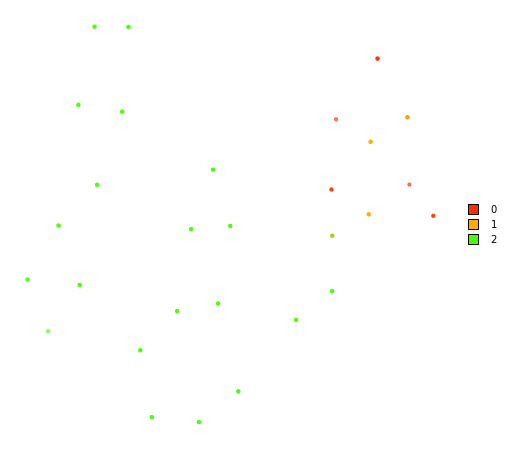

In [13]:
plot(emb_x_macro, y_crisis,s=10, colors=colors_bool)

## About charecteristics of individuals

In [14]:
data["x1"] = pd.DataFrame(['CHR2','CHR8','Totale']*26)
y_1 = data["x1"]

colors_chron = {
    'CHR2': "#FF2D00", 
    'CHR8': "#FFAC00", 
    'Totale': "#46FF00", 
}

In [15]:
x_carac = data[['CD_TY_CLI_RCI_1', 'CD_TY_CLI_RCI_2','CD_ETA_CIV_1', 'CD_ETA_CIV_2','CD_MOD_HABI_1', 
'CD_MOD_HABI_2','CD_PROF_1','CD_PROF_2', 'CD_PROF_3','CD_QUAL_VEH_1','CD_QUAL_VEH_2']]

In [16]:
%%time 
tsne = TSNE(perplexity=25, #preserve distances to a third of the data set 
            metric='euclidean', 
            n_components=2, #project on 1D 
            random_state=42,
            verbose=True)
emb_x_carac = tsne.fit(x_carac.to_numpy())

--------------------------------------------------------------------------------
TSNE(perplexity=25, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 75 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.0424, 50 iterations in 0.0139 sec
Iteration  100, KL divergence 0.8939, 50 iterations in 0.0167 sec
Iteration  150, KL divergence 0.6940, 50 iterations in 0.0151 sec
Iteration  200, KL divergence 0.5009, 50 iterations in 0.0142 sec
Iteration  250, KL divergence 0.4574, 50 iterations in 0.0136 sec
   --> Time elapsed: 0.07 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iteratio

In [17]:
emb_x_carac

TSNEEmbedding([[  8.55961421,  -1.4757729 ],
               [-14.39828516,   0.85743715],
               [  3.35414901,   1.38856756],
               [  8.79728106,  -1.64891292],
               [-14.26392364,   0.9005963 ],
               [  3.48205934,   1.4221176 ],
               [  8.83491529,  -1.67571922],
               [-14.14082965,   0.8987512 ],
               [  3.53435589,   1.46343625],
               [  8.94389643,  -1.75389347],
               [-14.10990603,   0.90612954],
               [  3.60042933,   1.47759084],
               [  9.14606195,  -1.88664464],
               [-14.33848428,   0.73017715],
               [  3.79191405,   1.51093206],
               [  9.23580648,  -1.94305511],
               [-14.29194333,   0.65789801],
               [  3.90820406,   1.5868234 ],
               [  9.36445734,  -2.02150052],
               [-13.93271658,   0.78440698],
               [  4.06291779,   1.67602437],
               [  9.40968795,  -2.06380656],
          

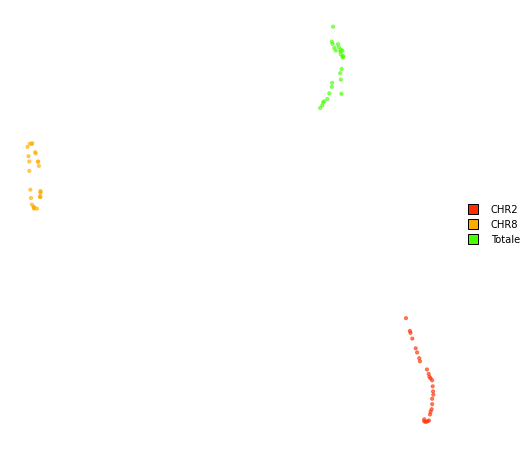

In [18]:
plot(emb_x_carac, y_1,s=10, colors=colors_chron)

## About subvariables factor link with chronique

In [19]:
data["x1"] = pd.DataFrame(['CHR2','CHR8','Totale']*26)
y_1 = data["x1"]

colors_chron = {
    'CHR2': "#FF2D00", 
    'CHR8': "#FFAC00", 
    'Totale': "#46FF00", 
}

In [20]:
x_1 = data[['mean_1','median_1','p5_1','p10_1','p25_1','p75_1','p90_1','p95_1']]

In [21]:
%%time 
tsne = TSNE(perplexity=25, #preserve distances to a third of the data set 
            metric='euclidean', 
            n_components=2, #project on 1D 
            random_state=42,
            verbose=True)
emb_x_1 = tsne.fit(x_1.to_numpy())

--------------------------------------------------------------------------------
TSNE(perplexity=25, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 75 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 0.4934, 50 iterations in 0.0145 sec
Iteration  100, KL divergence 0.5486, 50 iterations in 0.0163 sec
Iteration  150, KL divergence 0.5075, 50 iterations in 0.0186 sec
Iteration  200, KL divergence 0.6433, 50 iterations in 0.0272 sec
Iteration  250, KL divergence 0.5000, 50 iterations in 0.0186 sec
   --> Time elapsed: 0.10 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iteratio

In [22]:
emb_x_1

TSNEEmbedding([[-1.59738287e+01, -1.60481764e-01],
               [ 5.71243127e+00, -1.25694088e+01],
               [ 1.05311426e+01,  1.21770031e+01],
               [-1.59482240e+01, -3.10568279e-03],
               [ 5.70035271e+00, -1.24769682e+01],
               [ 1.04647612e+01,  1.21899043e+01],
               [-1.59480054e+01, -3.65240297e-03],
               [ 5.67985001e+00, -1.23331676e+01],
               [ 1.04368113e+01,  1.22033362e+01],
               [-1.60938418e+01,  8.23687571e-02],
               [ 5.65177980e+00, -1.21443611e+01],
               [ 1.03982741e+01,  1.22212360e+01],
               [-1.61358078e+01, -1.94589457e-01],
               [ 5.64933517e+00, -1.21434379e+01],
               [ 1.02785856e+01,  1.22989919e+01],
               [-1.61730340e+01, -1.66220324e-01],
               [ 5.64261597e+00, -1.20904510e+01],
               [ 1.02199311e+01,  1.23980744e+01],
               [-1.59853933e+01, -1.68895809e-01],
               [ 5.63513980e+00

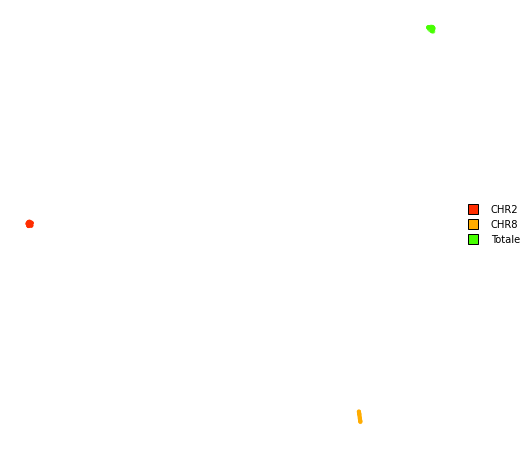

In [23]:
plot(emb_x_1, y_1,s=10, colors=colors_chron)

# Moins Kiff

## Analyzis of PD

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<AxesSubplot:xlabel='DR', ylabel='Count'>

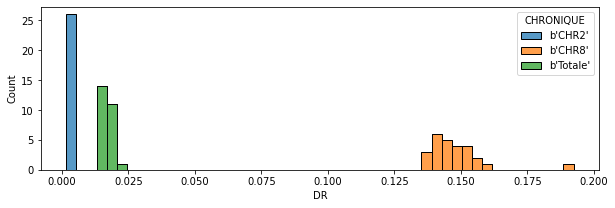

In [24]:
fig, ax = plt.subplots(figsize=(10,3))
sns.histplot(data=data, x="DR", hue="CHRONIQUE",multiple="stack",bins=50)

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<AxesSubplot:xlabel='DR', ylabel='Count'>

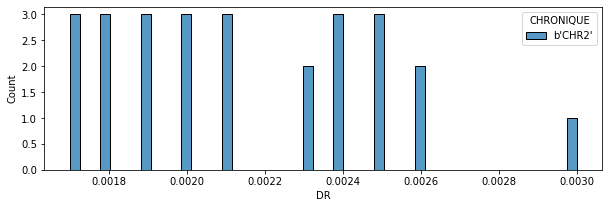

In [25]:
fig, ax = plt.subplots(figsize=(10,3))
sns.histplot(data=data1, x="DR", hue="CHRONIQUE",multiple="stack",bins=50)

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<AxesSubplot:xlabel='DR', ylabel='Count'>

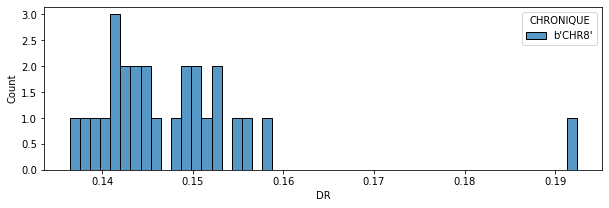

In [26]:
fig, ax = plt.subplots(figsize=(10,3))
sns.histplot(data=data2, x="DR", hue="CHRONIQUE",multiple="stack",bins=50)

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<AxesSubplot:xlabel='DR', ylabel='Count'>

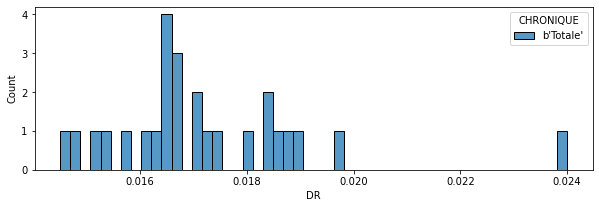

In [27]:
fig, ax = plt.subplots(figsize=(10,3))
sns.histplot(data=data3, x="DR", hue="CHRONIQUE",multiple="stack",bins=50)

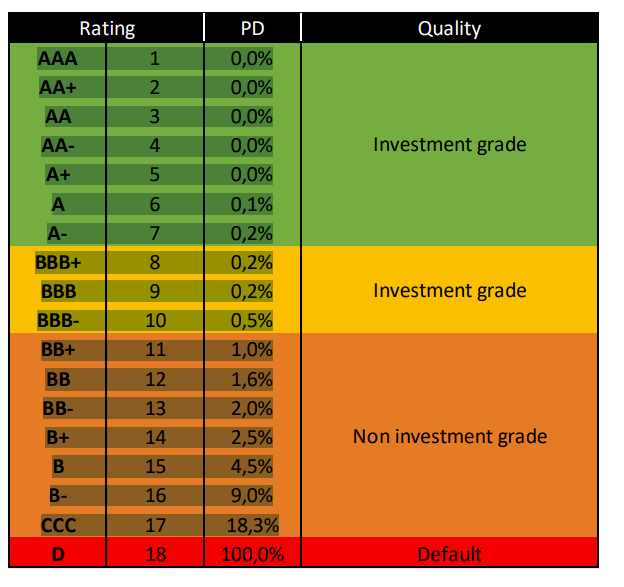

In [28]:
 def rating(dr):
  if dr<0.016:
    return 'A'
  elif 0.016<=dr<0.017:
    return 'B'
  elif 0.017<=dr<0.018:
    return 'C'
  elif 0.018<=dr<0.02:
    return 'D'
  else:
    return 'E'

In [29]:
data3['grade'] = data3['DR'].map(rating)
y_grade = data3['grade']
colors_grade = {
    'A': "#57D40A", 
    'B': "#9AD40A", 
    'C': "#D4D10A", 
    'D': "#FF8700", 
    'E': "#FF0C00", 
}

<ipython-input-29-cc624b0f9907>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['grade'] = data3['DR'].map(rating)


c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<AxesSubplot:xlabel='DR', ylabel='Count'>

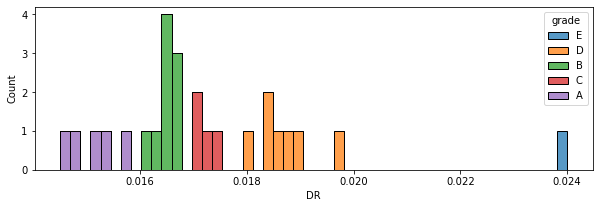

In [30]:
fig, ax = plt.subplots(figsize=(10,3))
sns.histplot(data=data3, x="DR", hue="grade",multiple="stack",bins=50)

Perplexity value 25 is too high. Using perplexity 8.33 instead


--------------------------------------------------------------------------------
TSNE(perplexity=25, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 25 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.0773, 50 iterations in 0.0087 sec
Iteration  100, KL divergence 1.2416, 50 iterations in 0.0070 sec
Iteration  150, KL divergence 1.4785, 50 iterations in 0.0072 sec
Iteration  200, KL divergence 1.2504, 50 iterations in 0.0089 sec
Iteration  250, KL divergence 1.1509, 50 iterations in 0.0072 sec
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iteratio

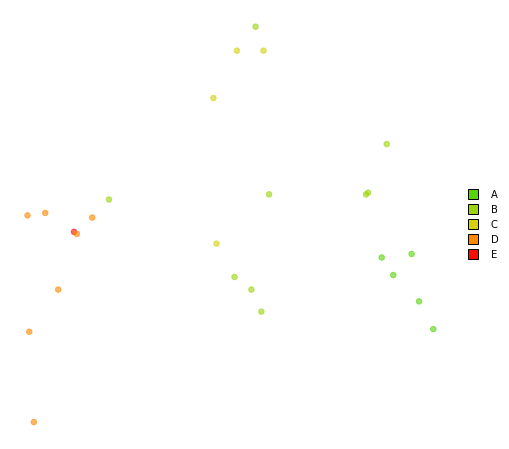

In [31]:
x_macro_3 = data3[["PIB","Inflation","Tx_cho"]]
tsne = TSNE(perplexity=25, #preserve distances to a third of the data set 
            metric='euclidean', 
            n_components=2, #project on 1D 
            random_state=42,
            verbose=True)
emb_x_macro_3 = tsne.fit(x_macro_3.to_numpy())
plot(emb_x_macro_3, y_grade,s=30, colors=colors_grade)

Perplexity value 25 is too high. Using perplexity 8.33 instead


--------------------------------------------------------------------------------
TSNE(perplexity=25, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 25 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.4738, 50 iterations in 0.0073 sec
Iteration  100, KL divergence 1.4555, 50 iterations in 0.0087 sec
Iteration  150, KL divergence 1.4996, 50 iterations in 0.0061 sec
Iteration  200, KL divergence 1.0330, 50 iterations in 0.0090 sec
Iteration  250, KL divergence 1.1872, 50 iterations in 0.0085 sec
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iteratio

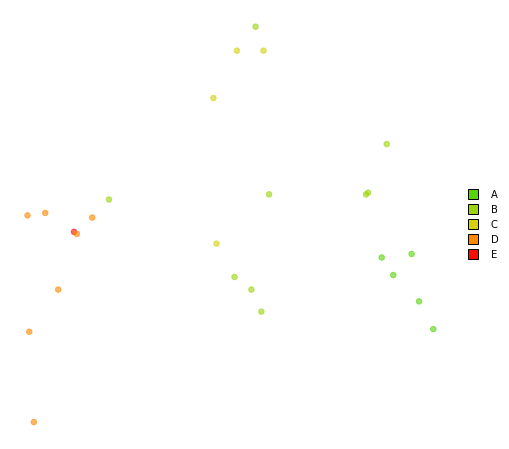

In [32]:
x_carac = data3[['CD_TY_CLI_RCI_1', 'CD_TY_CLI_RCI_2','CD_ETA_CIV_1', 'CD_ETA_CIV_2','CD_MOD_HABI_1', 
'CD_MOD_HABI_2','CD_PROF_1','CD_PROF_2', 'CD_PROF_3','CD_QUAL_VEH_1','CD_QUAL_VEH_2']]
tsne = TSNE(perplexity=25, #preserve distances to a third of the data set 
            metric='euclidean', 
            n_components=2, #project on 1D 
            random_state=42,
            verbose=True)
emb_x_carac3 = tsne.fit(x_carac.to_numpy())
plot(emb_x_macro_3, y_grade,s=30, colors=colors_grade)

Perplexity value 25 is too high. Using perplexity 8.33 instead


--------------------------------------------------------------------------------
TSNE(perplexity=25, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 25 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.4208, 50 iterations in 0.0074 sec
Iteration  100, KL divergence 1.2374, 50 iterations in 0.0095 sec
Iteration  150, KL divergence 1.3924, 50 iterations in 0.0071 sec
Iteration  200, KL divergence 1.5607, 50 iterations in 0.0081 sec
Iteration  250, KL divergence 1.4269, 50 iterations in 0.0083 sec
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iteratio

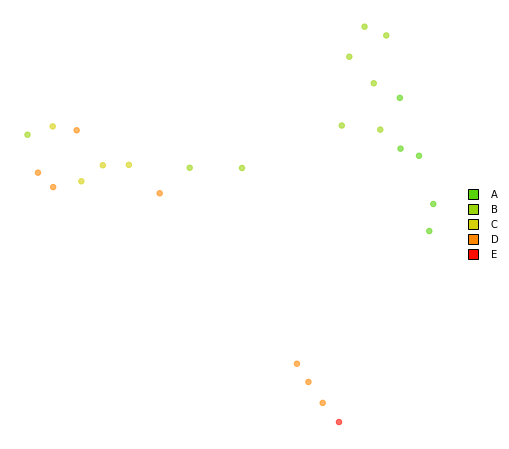

In [33]:
x_1_3 = data3[['mean_1','median_1','p5_1','p10_1','p25_1','p75_1','p90_1','p95_1']]
tsne = TSNE(perplexity=25, #preserve distances to a third of the data set 
            metric='euclidean', 
            n_components=2, #project on 1D 
            random_state=42,
            verbose=True)
emb_x_1_3 = tsne.fit(x_1_3.to_numpy())
plot(emb_x_1_3, y_grade,s=30, colors=colors_grade)

## Bivariate analysis

In [34]:
data3.columns

Index(['TRIMESTRE', 'CHRONIQUE', 'DR', 'mean_1', 'median_1', 'p5_1', 'p10_1',
       'p25_1', 'p75_1', 'p90_1', 'p95_1', 'mean_2', 'median_2', 'p5_2',
       'p10_2', 'p25_2', 'p75_2', 'p90_2', 'p95_2', 'mean_3', 'median_3',
       'p5_3', 'p10_3', 'p25_3', 'p75_3', 'p90_3', 'p95_3', 'mean_4',
       'median_4', 'p5_4', 'p10_4', 'p25_4', 'p75_4', 'p90_4', 'p95_4',
       'mean_5', 'median_5', 'p5_5', 'p10_5', 'p25_5', 'p75_5', 'p90_5',
       'p95_5', 'mean_6', 'median_6', 'p5_6', 'p10_6', 'p25_6', 'p75_6',
       'p90_6', 'p95_6', 'mean_7', 'median_7', 'p5_7', 'p10_7', 'p25_7',
       'p75_7', 'p90_7', 'p95_7', 'mean_8', 'median_8', 'p5_8', 'p10_8',
       'p25_8', 'p75_8', 'p90_8', 'p95_8', 'CD_TY_CLI_RCI_1',
       'CD_TY_CLI_RCI_2', 'CD_ETA_CIV_1', 'CD_ETA_CIV_2', 'CD_MOD_HABI_1',
       'CD_MOD_HABI_2', 'CD_PROF_1', 'CD_PROF_2', 'CD_PROF_3', 'CD_QUAL_VEH_1',
       'CD_QUAL_VEH_2', 'dtf_per_trt', 'PIB', 'Inflation', 'Tx_cho', 'grade'],
      dtype='object')

In [35]:
cols = ['CD_TY_CLI_RCI_1', 'CD_TY_CLI_RCI_2', 'CD_ETA_CIV_1', 'CD_ETA_CIV_2', 'CD_MOD_HABI_1',
       'CD_MOD_HABI_2', 'CD_PROF_1', 'CD_PROF_2', 'CD_PROF_3', 'CD_QUAL_VEH_1',
       'CD_QUAL_VEH_2']

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


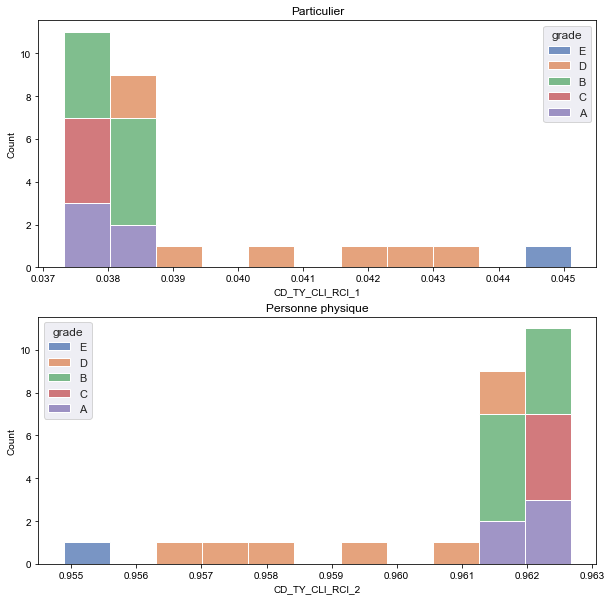

In [36]:
fig, axs = plt.subplots(2, figsize=(10, 10))
sns.set(style="darkgrid")
sns.histplot(data=data3, x='CD_TY_CLI_RCI_1', hue='grade',multiple="stack", ax=axs[0])
axs[0].set_title("Particulier")
sns.histplot(data=data3, x='CD_TY_CLI_RCI_2', hue='grade',multiple="stack", ax=axs[1])
axs[1].set_title("Personne physique")
plt.show()

Plus il y a de particulier et moins il y a un risque de défault

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


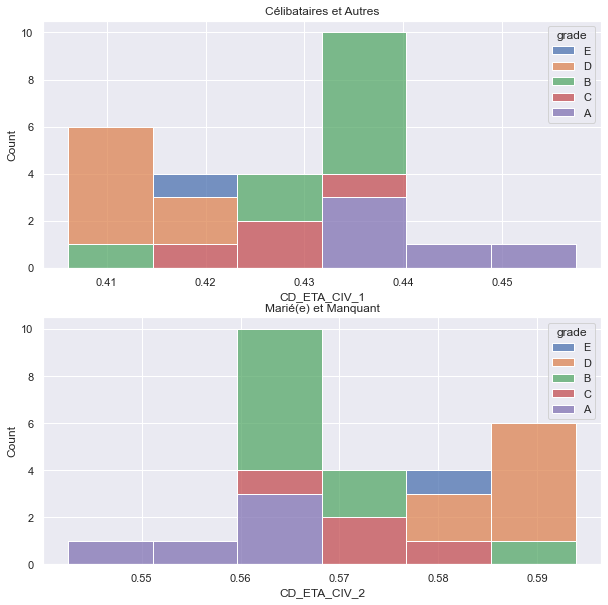

In [37]:
fig, axs = plt.subplots(2, figsize=(10, 10))
sns.set(style="darkgrid")
sns.histplot(data=data3, x='CD_ETA_CIV_1', hue='grade',multiple="stack", ax=axs[0])
axs[0].set_title("Célibataires et Autres")
sns.histplot(data=data3, x='CD_ETA_CIV_2',hue='grade',multiple="stack",ax=axs[1])
axs[1].set_title("Marié(e) et Manquant")
plt.show()

Plus la répartition de la situation amouereuse des gens est moitié moitié et moins DR est grand

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


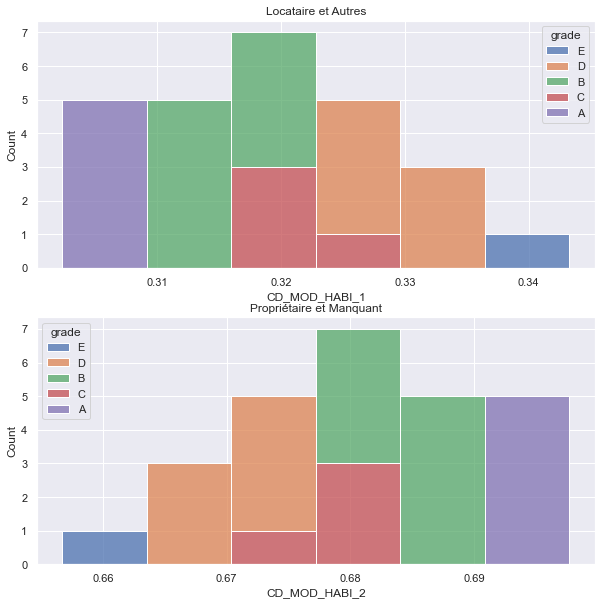

In [38]:
fig, axs = plt.subplots(2, figsize=(10, 10))
sns.set(style="darkgrid")
sns.histplot(data=data3, x='CD_MOD_HABI_1', hue='grade',multiple="stack",ax=axs[0])
axs[0].set_title("Locataire et Autres")
sns.histplot(data=data3, x='CD_MOD_HABI_2', hue='grade',multiple="stack",ax=axs[1])
axs[1].set_title("Propriétaire et Manquant")
plt.show()

Plus il y a de locataire et moins DR et grand

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


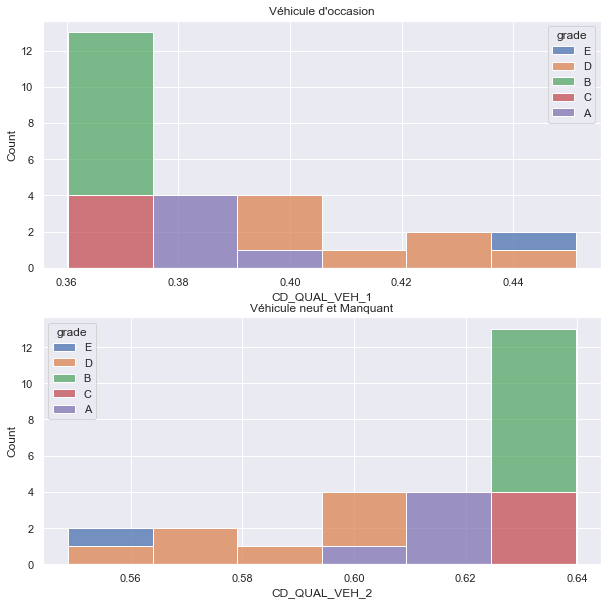

In [39]:
fig, axs = plt.subplots(2, figsize=(10, 10))
sns.set(style="darkgrid")
sns.histplot(data=data3, x='CD_QUAL_VEH_1', hue='grade',multiple="stack",ax=axs[0])
axs[0].set_title("Véhicule d'occasion")
sns.histplot(data=data3, x='CD_QUAL_VEH_2', hue='grade',multiple="stack",ax=axs[1])
axs[1].set_title("Véhicule neuf et Manquant")
plt.show()

On n'en déduit pas grand chose

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use eithe

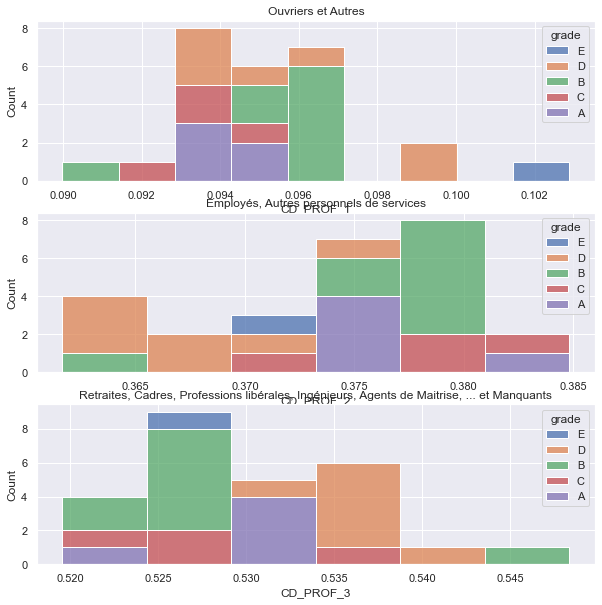

In [40]:
fig, axs = plt.subplots(3, figsize=(10, 10))
sns.set(style="darkgrid")
sns.histplot(data=data3, x='CD_PROF_1', hue='grade',multiple="stack", ax=axs[0])
axs[0].set_title("Ouvriers et Autres")
sns.histplot(data=data3, x='CD_PROF_2', hue='grade',multiple="stack", ax=axs[1])
axs[1].set_title("Employés, Autres personnels de services")
sns.histplot(data=data3, x='CD_PROF_3', hue='grade',multiple="stack", ax=axs[2])
axs[2].set_title("Retraites, Cadres, Professions libérales, Ingénieurs, Agents de Maitrise, ... et Manquants")
plt.show()

On n'en déduit pas grand chose

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use eithe

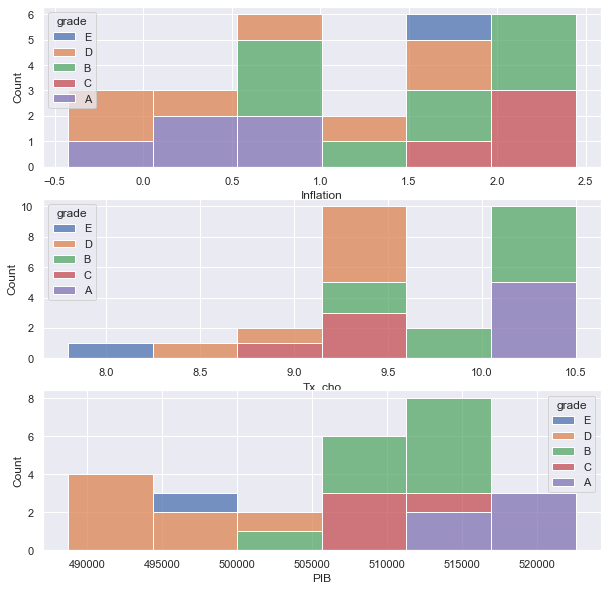

In [41]:
fig, axs = plt.subplots(3, figsize=(10, 10))
sns.set(style="darkgrid")
sns.histplot(data=data3, x='Inflation', hue='grade',multiple="stack", ax=axs[0])
sns.histplot(data=data3, x='Tx_cho', hue='grade',multiple="stack", ax=axs[1])
sns.histplot(data=data3, x='PIB', hue='grade',multiple="stack", ax=axs[2])
plt.show()

On déduit rien de l'inflation
étonnamment, plus le taux de chomage est élevé et plus DR est petit
Plus le PIB est grand, plus DR est petit


## Decision tree

In [42]:
data.columns

Index(['TRIMESTRE', 'CHRONIQUE', 'DR', 'mean_1', 'median_1', 'p5_1', 'p10_1',
       'p25_1', 'p75_1', 'p90_1', 'p95_1', 'mean_2', 'median_2', 'p5_2',
       'p10_2', 'p25_2', 'p75_2', 'p90_2', 'p95_2', 'mean_3', 'median_3',
       'p5_3', 'p10_3', 'p25_3', 'p75_3', 'p90_3', 'p95_3', 'mean_4',
       'median_4', 'p5_4', 'p10_4', 'p25_4', 'p75_4', 'p90_4', 'p95_4',
       'mean_5', 'median_5', 'p5_5', 'p10_5', 'p25_5', 'p75_5', 'p90_5',
       'p95_5', 'mean_6', 'median_6', 'p5_6', 'p10_6', 'p25_6', 'p75_6',
       'p90_6', 'p95_6', 'mean_7', 'median_7', 'p5_7', 'p10_7', 'p25_7',
       'p75_7', 'p90_7', 'p95_7', 'mean_8', 'median_8', 'p5_8', 'p10_8',
       'p25_8', 'p75_8', 'p90_8', 'p95_8', 'CD_TY_CLI_RCI_1',
       'CD_TY_CLI_RCI_2', 'CD_ETA_CIV_1', 'CD_ETA_CIV_2', 'CD_MOD_HABI_1',
       'CD_MOD_HABI_2', 'CD_PROF_1', 'CD_PROF_2', 'CD_PROF_3', 'CD_QUAL_VEH_1',
       'CD_QUAL_VEH_2', 'dtf_per_trt', 'PIB', 'Inflation', 'Tx_cho', 'crisis',
       'x1'],
      dtype='object')

In [43]:

target_names = ['A','B','C','D','E']

feature_names = ['CD_TY_CLI_RCI_1', 'CD_ETA_CIV_1', 'CD_MOD_HABI_1', 'CD_PROF_1', 'CD_PROF_2', 'CD_QUAL_VEH_1', 'PIB', 'Inflation', 'Tx_cho']


In [44]:
Y = data3['grade']
X = data3[feature_names]

In [45]:
X_train = X[:int(X.shape[0]*0.7)]
X_test = X[int(X.shape[0]*0.7):]
Y_train = Y[:int(X.shape[0]*0.7)]
Y_test = Y[int(X.shape[0]*0.7):]

<ipython-input-45-2b47426beaff>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Y_train = Y[:int(X.shape[0]*0.7)]
<ipython-input-45-2b47426beaff>:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Y_test = Y[int(X.shape[0]*0.7):]


In [46]:
clf = tree.DecisionTreeClassifier(max_depth=8)
clf = clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.375

On déduit que des variables assez importantes sont: 
* 'Tx_cho'
*   'CD_MOD_HABI_2'
*   'CD_TY_CLI_RCI_1'

On vérifie avec la matrice de corrélation


<ipython-input-50-58d11fe589bb>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  MatriceCorrelation3=data3.drop(data3.iloc[:, 3:3+8*8],axis = 1).corr()


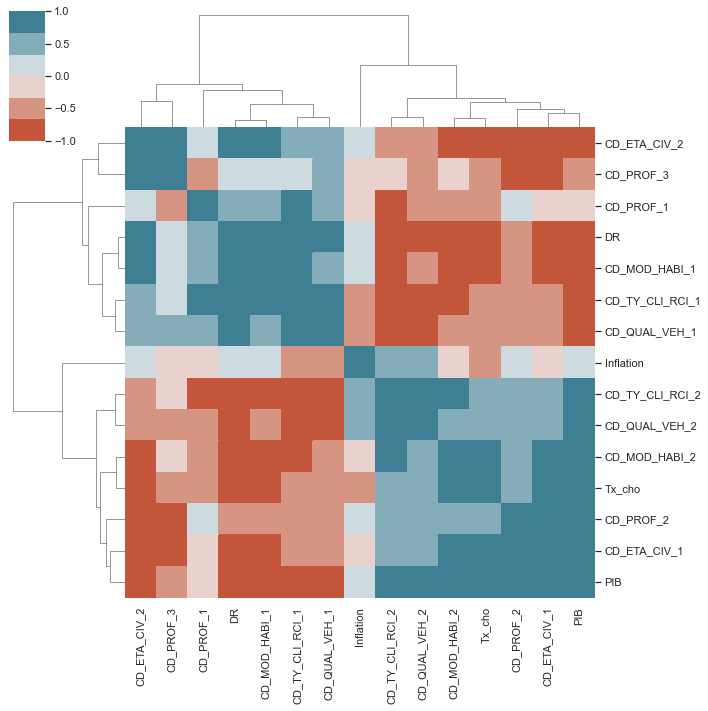

In [50]:
MatriceCorrelation3=data3.drop(data3.iloc[:, 3:3+8*8],axis = 1).corr()
sns.clustermap(MatriceCorrelation3, fmt='.2f', cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0)